
# Спрос на рейсы авиакомпании


**Цель работы:**  Построить модель со значением метрики качества F1 не меньше 0.75.  

**Цель применния** : Определить предпочтения пользователей, покупающих билеты на разные направления.

**Исходные данные**:  В распоряжении набор данных с разметкой о токсичности правок.

### Содержание:
* Подготовка
* Обучение моделей
* Вывод


## Подготовка 

In [15]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import SVC, LinearSVC 
from sklearn.linear_model import LogisticRegression 
from pymystem3 import Mystem
m = Mystem() 
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Параметры предупреждений
warnings.simplefilter('ignore')


In [2]:
data= pd.read_csv('toxic_comments.csv')
display(data.head())
display(data.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

Набор данных из двух столбцов: комментарии и целевой признак.

In [3]:
print('Кол-во дубликатов',data.duplicated().sum())

Кол-во дубликатов 0


In [4]:
data.groupby('toxic').size()

toxic
0    143346
1     16225
dtype: int64

При обучении моделей учтем явный дисбаланс классов

Создадим корпус постов. Преобразуем столбец **text** в список текстов. Переведём тексты в стандартный для Python формат: кодировку Unicode (U).

In [5]:
corpus = data['text'].values.astype('U')

Напишем функцию **lemmatize(text)** для лемматизации комментариев

In [6]:
def lemmatize(text):
    lemm_list = m.lemmatize(clear_text(text))
    lemm_text = "".join(lemm_list)
    return lemm_text

Напишем функцию **clear_text(text)**, которая оставит в тексте только кириллические символы и пробелы.

In [7]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

In [8]:
print("Оригинальный комментарий", corpus[0])
print("Очищенный и лемматизированный комментарий:", lemmatize(corpus[0]))

Оригинальный комментарий Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Очищенный и лемматизированный комментарий: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now



Применим функции **lemmatize(text)** и **clear_text(text)** ко всему набору данных

In [9]:
data['text'] = data['text'].apply(lemmatize)
data.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0



## Обучение моделей


In [10]:
data.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


Разбиваем данные на обучающий и тестовый набор

In [11]:
features_train, features_test, target_train, target_test = train_test_split(data['text'],data['toxic'],test_size=0.25)

In [12]:
print("Размер обучающего набора: {}\nРазмер тестового набора:"
         " {}\n".format(features_train.shape[0], features_test.shape[0],))

Размер обучающего набора: 119678
Размер тестового набора: 39893



Загрузим список стоп-слов

In [16]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим счётчик, указав в нём стоп-слова и посчитаем TD-IDF

In [17]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
count_tf_idf.fit(features_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

Конвертируем на  обучающий и тестовый набор

In [18]:
features_train_tf = count_tf_idf.transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

## Обучение LogisticRegression без баланса классов

In [19]:
model_lr = LogisticRegression(random_state = 12345)

In [20]:
print('Качество метрики F1:',(cross_val_score(model_lr,features_train_tf, target_train,cv=3,scoring='f1')).mean())

Качество метрики F1: 0.697981600392477


Качество метрики F1 достаточно низкое с учетом дисбаланса классов

### Тестирование

In [21]:
model_lr.fit(features_train_tf, target_train)
predicted = model_lr.predict(features_test_tf)
f1_score(target_test, predicted)

0.7229916897506926

Качество метрики F1  нас не удовлетворяет

Напишем функцию матрицы ошибок:

In [22]:
def conf_matrix(model, features, target):

    pred = model.predict(features)
    conf_matrix = confusion_matrix(target, pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.title('Confusion matrix')

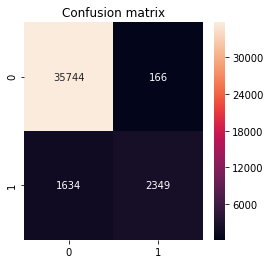

In [23]:
conf_matrix(model_lr, features_test_tf, target_test)

## Обучение LogisticRegression с балансом классов

In [24]:
model_lr_balanced = LogisticRegression(class_weight='balanced',random_state = 12345)

In [25]:
print('Качество метрики F1 c учетом баланса классов:',(cross_val_score(model_lr_balanced,features_train_tf, target_train,cv=3,scoring='f1')).mean())

Качество метрики F1 c учетом баланса классов: 0.7510732999213929


Качество метрики F1 c учетом баланса классов выше требуемого

### Тестирование

In [26]:
model_lr_balanced.fit(features_train_tf, target_train)
predicted = model_lr_balanced.predict(features_test_tf)
f1_score(target_test, predicted)

0.7470386361120336

Качество метрики F1  очень близко к 0.75

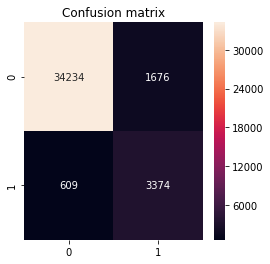

In [27]:
conf_matrix(model_lr_balanced, features_test_tf, target_test)

## Обучение LinearSVC без баланса классов

In [28]:
SVM = LinearSVC(random_state = 12345)

In [29]:
print('Качество метрики F1:',(cross_val_score(SVM,features_train_tf, target_train,cv=3,scoring='f1')).mean())

Качество метрики F1: 0.7686565803482205


Качество метрики F1 нас устраивает

### Тестирование

In [30]:
SVM.fit(features_train_tf, target_train)
predicted = SVM.predict(features_test_tf)
f1_score(target_test, predicted)

0.7792062604807155

Качество метрики F1 нас устраивает

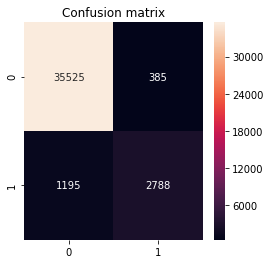

In [31]:
conf_matrix(SVM, features_test_tf, target_test)

## Обучение LinearSVC c балансом классов

In [32]:
SVM_balanced = LinearSVC(random_state = 12345,class_weight='balanced')

In [33]:
print('Качество метрики F1:',(cross_val_score(SVM_balanced,features_train_tf, target_train,cv=3,scoring='f1')).mean())

Качество метрики F1: 0.7640031594159619


Качество метрики F1 нас устраивает

### Тестирование

In [34]:
SVM_balanced.fit(features_train_tf, target_train)
predicted = SVM_balanced.predict(features_test_tf)
f1_score(target_test, predicted)

0.7612660312977997

Качество метрики F1 нас устраивает

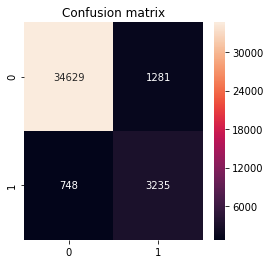

In [35]:
conf_matrix(SVM_balanced, features_test_tf, target_test)


## Вывод 


Рассматривали только эти две модели: они просты и быстрые, другие же модели имеют долгое время обучения. Пользователь ограничен в ресурсе мощностей
* LinearSVC на тесте и на трейне показал F1>0.75  
* LogisticRegression на тесте <0.75, однако на трейне с учетом баланса классов выше указанного  
Стоит заметить, как искусственый баланс классов увеличивает долю ошибочно позитивных комментариев.